In [1]:
import json
import numpy as np
import pandas as pd
print(np.__version__)
print(pd.__version__)

# with open('tmp.json', 'w') as f:
#     json.dump(result, f)

# with open('tmp.json', 'r') as f:
#     tmp = json.load(f)

1.12.1
0.20.3


## price change per 10 minutes (9:30-15:50 ET)

In [14]:
df = pd.read_csv('tesla_price.csv', dtype={'date':'str'})
df['date_time'] = df['date'] + df['time'].str.replace(':','')
df.head()

,price,date,time,date_time
0,70.95,0301,09:30,03010930
1,70.85,0301,09:40,03010940
2,70.70,0301,09:50,03010950
3,70.59,0301,10:00,03011000
4,70.52,0301,10:10,03011010


In [15]:
change = []
for i in range(6):
    for j in range(38):
        prev = df.iloc[i * 39 + j]
        curr = df.iloc[i * 39 + j + 1]
        delta = (curr['price'] - prev['price']) * 10000 / prev['price']
        row = [prev['date_time'], curr['date_time'], prev['price'], curr['price'], round(delta, 1)]
        change.append(row)

df_out = pd.DataFrame(change, columns = ['time1', 'time2', 'price1', 'price2', 'delta'])
df_out.head()

,time1,time2,price1,price2,delta
0,03010930,03010940,70.95,70.85,-14.1
1,03010940,03010950,70.85,70.70,-21.2
2,03010950,03011000,70.70,70.59,-15.6
3,03011000,03011010,70.59,70.52,-9.9
4,03011010,03011020,70.52,70.55,4.3


In [16]:
df_out.to_csv('tesla_price_change.csv', index=False)

## tweets
##### (GMT - 5 hours = ET)

In [2]:
from datetime import datetime, timedelta

def adjust_time(GMT):
    tmp = datetime.strptime(GMT, "%a %b %d %H:%M:%S +0000 %Y") - timedelta(hours=5)
    ET = tmp.strftime("%m%d%H%M")
    return ET

In [14]:
import re

def text_simplify(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())

def get_video_url(variants):
    smallest = 0
    url = ''
    for variant in variants:
        if 'bitrate' in variant and (smallest == 0 or smallest > variant['bitrate']):
            smallest = variant['bitrate']
            url = variant['url']
    return url

import pytesseract 
from PIL import Image
import requests
from StringIO import StringIO

def get_text_from_photo(url):
    response = requests.get(url)
    img = Image.open(StringIO(response.content))
    try:
        return pytesseract.image_to_string(img, lang='eng')
    except:
        return ''

import speech_recognition as sr
import subprocess

def get_text_from_video(url):
    r = requests.get(url)
    with open("video.mp4", "wb") as handle:
        for data in r.iter_content():
            handle.write(data)
            
    cmds = ['ffmpeg', '-y', '-i', 'video.mp4', '-acodec', 'pcm_s16le', '-ac', '2', 'audio.wav']
    subprocess.Popen(cmds)
    r = sr.Recognizer()
    with sr.AudioFile('audio.wav') as source:
        audio = r.record(source)
        
    try:
        return r.recognize_google(audio)
    except:
        return ''

In [50]:
with open('verizon_mixed.json', 'r') as f:
    tweets = json.load(f)
print(len(tweets))

33100


In [51]:
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=len(tweets))
display(f)

rows = []
for tweet in tweets:
    row = [adjust_time(tweet['created_at'])]
    row.append(tweet['favorite_count'])
    row.append(tweet['id_str'])
    row.append(tweet['retweet_count'])
    row.append(tweet['user']['followers_count'])
    row.append(tweet['truncated'])
    text = text_simplify(tweet['text'])
    if 'extended_entities' in tweet:
        for media in tweet['extended_entities']['media']:
            if 'additional_media_info' in media:
                if 'title' in media['additional_media_info']:
                    text = text + ' ' + text_simplify(media['additional_media_info']['title'])
                if 'description' in media['additional_media_info']:
                    text = text + ' ' + text_simplify(media['additional_media_info']['description'])
            if 'type' in media:
                if media['type'] == 'photo':
                    try: text = text + ' ' + text_simplify(get_text_from_photo(media['media_url_https']))   
                    except Exception as e: print(e)
                if media['type'] == 'video':
                    variants = media['video_info']['variants']
                    try: text = text + ' ' + text_simplify(get_text_from_video(get_video_url(variants)))
                    except Exception as e: print(e)
    row.append(text)
    rows.append(row)
    f.value += 1
    
df_out = pd.DataFrame(rows, columns=['created_at','favorite_count','id_str','retweet_count','followers_count','truncated','text'])
df_out.head()

A Jupyter Widget

cannot identify image file <StringIO.StringIO instance at 0x169ea7368>
cannot identify image file <StringIO.StringIO instance at 0x10aca0ea8>
cannot identify image file <StringIO.StringIO instance at 0x10c9f0098>


,created_at,favorite_count,id_str,retweet_count,followers_count,truncated,text
0,03081504,284,1104110574932127744,66,2419,True,is now playing on these platforms and more Alt...
1,03081401,331,1104094893276913665,59,1811911,False,This is home to me In this insider explains wh...
2,03080815,70,1104007610364121088,33,11414799,True,This International Women s Day CARE and Verizo...
3,03090026,0,1104252030766333952,10836,121,False,RT Verizon You re all out of data You ve been ...
4,03090026,0,1104251998210265088,10836,349,False,RT Verizon You re all out of data You ve been ...


In [52]:
df_out.to_csv('verizon_mixed_text.csv', index=False)

---
## experiments

### for text (by regular expression)
1. remove: @ #
2. remove: links
3. unicode : nltk.word_tokenize(tmp['text'].encode('utf-8').decode('utf8'))

In [66]:
import re
for i in range(20):
    print(tweets[i]['text'])
    print(' '.join(re.sub("([@#][A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweets[i]['text']).split()))
    print('-------------------')

Introducing V3 Supercharging
Introducing V3 Supercharging
-------------------
Tesla's launched its brand-new, 250 kW Superchargers, but more interestingly its updating the software of the Model… https://t.co/wXDzIytStd
Tesla s launched its brand new 250 kW Superchargers but more interestingly its updating the software of the Model
-------------------
This guy rebuilt a Tesla in his driveway. Pretty damn impressive https://t.co/tNF0WkFVbt
This guy rebuilt a Tesla in his driveway Pretty damn impressive
-------------------
Elon Tesla and Bill Microsoft must be pretty jealous of all the praise Tim Apple is getting from @realDonaldTrump t… https://t.co/mnBpPCOHlt
Elon Tesla and Bill Microsoft must be pretty jealous of all the praise Tim Apple is getting from t
-------------------
"Tim Apple" 😂🤦🏽‍♂️😂

Next up we have...

Sundar Google?
Bill Microsoft?
Elon Tesla? https://t.co/Bpo8rh1mK0
Tim Apple Next up we have Sundar Google Bill Microsoft Elon Tesla
-------------------
After finally releas

### for video (by SpeechRecognition)

In [40]:
for tweet in tweets:
    if 'media' in tweet['entities']:
        tmp = tweet
        break
        
tmp

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Thu Mar 07 18:00:01 +0000 2019',
 u'entities': {u'hashtags': [],
  u'media': [{u'display_url': u'pic.twitter.com/jOHPdNgmf7',
    u'expanded_url': u'https://twitter.com/DRIVETRIBE/status/1103716948976771073/video/1',
    u'id': 1103331872808071168,
    u'id_str': u'1103331872808071168',
    u'indices': [54, 77],
    u'media_url': u'http://pbs.twimg.com/amplify_video_thumb/1103331872808071168/img/UBuSIddgnVLJ-vQ6.jpg',
    u'media_url_https': u'https://pbs.twimg.com/amplify_video_thumb/1103331872808071168/img/UBuSIddgnVLJ-vQ6.jpg',
    u'sizes': {u'large': {u'h': 720, u'resize': u'fit', u'w': 1280},
     u'medium': {u'h': 675, u'resize': u'fit', u'w': 1200},
     u'small': {u'h': 383, u'resize': u'fit', u'w': 680},
     u'thumb': {u'h': 150, u'resize': u'crop', u'w': 150}},
    u'type': u'photo',
    u'url': u'https://t.co/jOHPdNgmf7'}],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': [{u'id': 44196397,
    u'id_str':

In [80]:
# https://t.co/jOHPdNgmf7
# https://video.twimg.com/amplify_video/1103331872808071168/vid/320x180/Y9FpZymERRip9Dk5.mp4?tag=9

import requests
import speech_recognition as sr
import subprocess

url = 'https://video.twimg.com/ext_tw_video/1100819179769344001/pu/vid/320x568/559pqLnvB3hZj3uj.mp4?tag=6'
r = requests.get(url)

with open("video.mp4", "wb") as handle:
    for data in r.iter_content():
        handle.write(data)
        
cmds = ['ffmpeg', '-y', '-i', 'video.mp4', '-acodec', 'pcm_s16le', '-ac', '2', 'audio.wav']
subprocess.Popen(cmds)

In [81]:
r = sr.Recognizer()
with sr.AudioFile('audio.wav') as source:
    audio = r.record(source)

command = r.recognize_google(audio)
print command

okay I promise I didn't set this up a perfect reason of why you might want to use summon Parks like that


### for photo (by Pytesseract)

In [82]:
for tweet in tweets:
    if tweet['id_str'] == '1101244591141990400':
        tmp = tweet
        break
        
tmp

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Thu Feb 28 22:15:45 +0000 2019',
 u'entities': {u'hashtags': [],
  u'media': [{u'display_url': u'pic.twitter.com/CCw1Kx7lU7',
    u'expanded_url': u'https://twitter.com/CARandDRIVER/status/1101244591141990400/photo/1',
    u'id': 1101244588981932033,
    u'id_str': u'1101244588981932033',
    u'indices': [103, 126],
    u'media_url': u'http://pbs.twimg.com/media/D0hoHnkW0AE-vWc.jpg',
    u'media_url_https': u'https://pbs.twimg.com/media/D0hoHnkW0AE-vWc.jpg',
    u'sizes': {u'large': {u'h': 893, u'resize': u'fit', u'w': 1527},
     u'medium': {u'h': 702, u'resize': u'fit', u'w': 1200},
     u'small': {u'h': 398, u'resize': u'fit', u'w': 680},
     u'thumb': {u'h': 150, u'resize': u'crop', u'w': 150}},
    u'type': u'photo',
    u'url': u'https://t.co/CCw1Kx7lU7'}],
  u'symbols': [],
  u'urls': [{u'display_url': u'crdrv.co/04oxR5e',
    u'expanded_url': u'http://crdrv.co/04oxR5e',
    u'indices': [79, 102],
    u'url': u'ht

In [90]:
import pytesseract 
from PIL import Image
import requests
from StringIO import StringIO

url = 'https://pbs.twimg.com/media/D0hoHnkW0AE-vWc.jpg'
url = 'https://s3.amazonaws.com/stackabuse/media/pytesseract-simple-python-optical-character-recognition-4.png'
response = requests.get(url)
img = Image.open(StringIO(response.content))
str = pytesseract.image_to_string(img, lang='eng')
print(str)

Successfully processed

Upload new File

Choose ﬁle No ﬁle chosen Upload

Result:

A Python Approach to Character
Recognition

The extracted text from the image above is: A Python Approach to Character Recognition


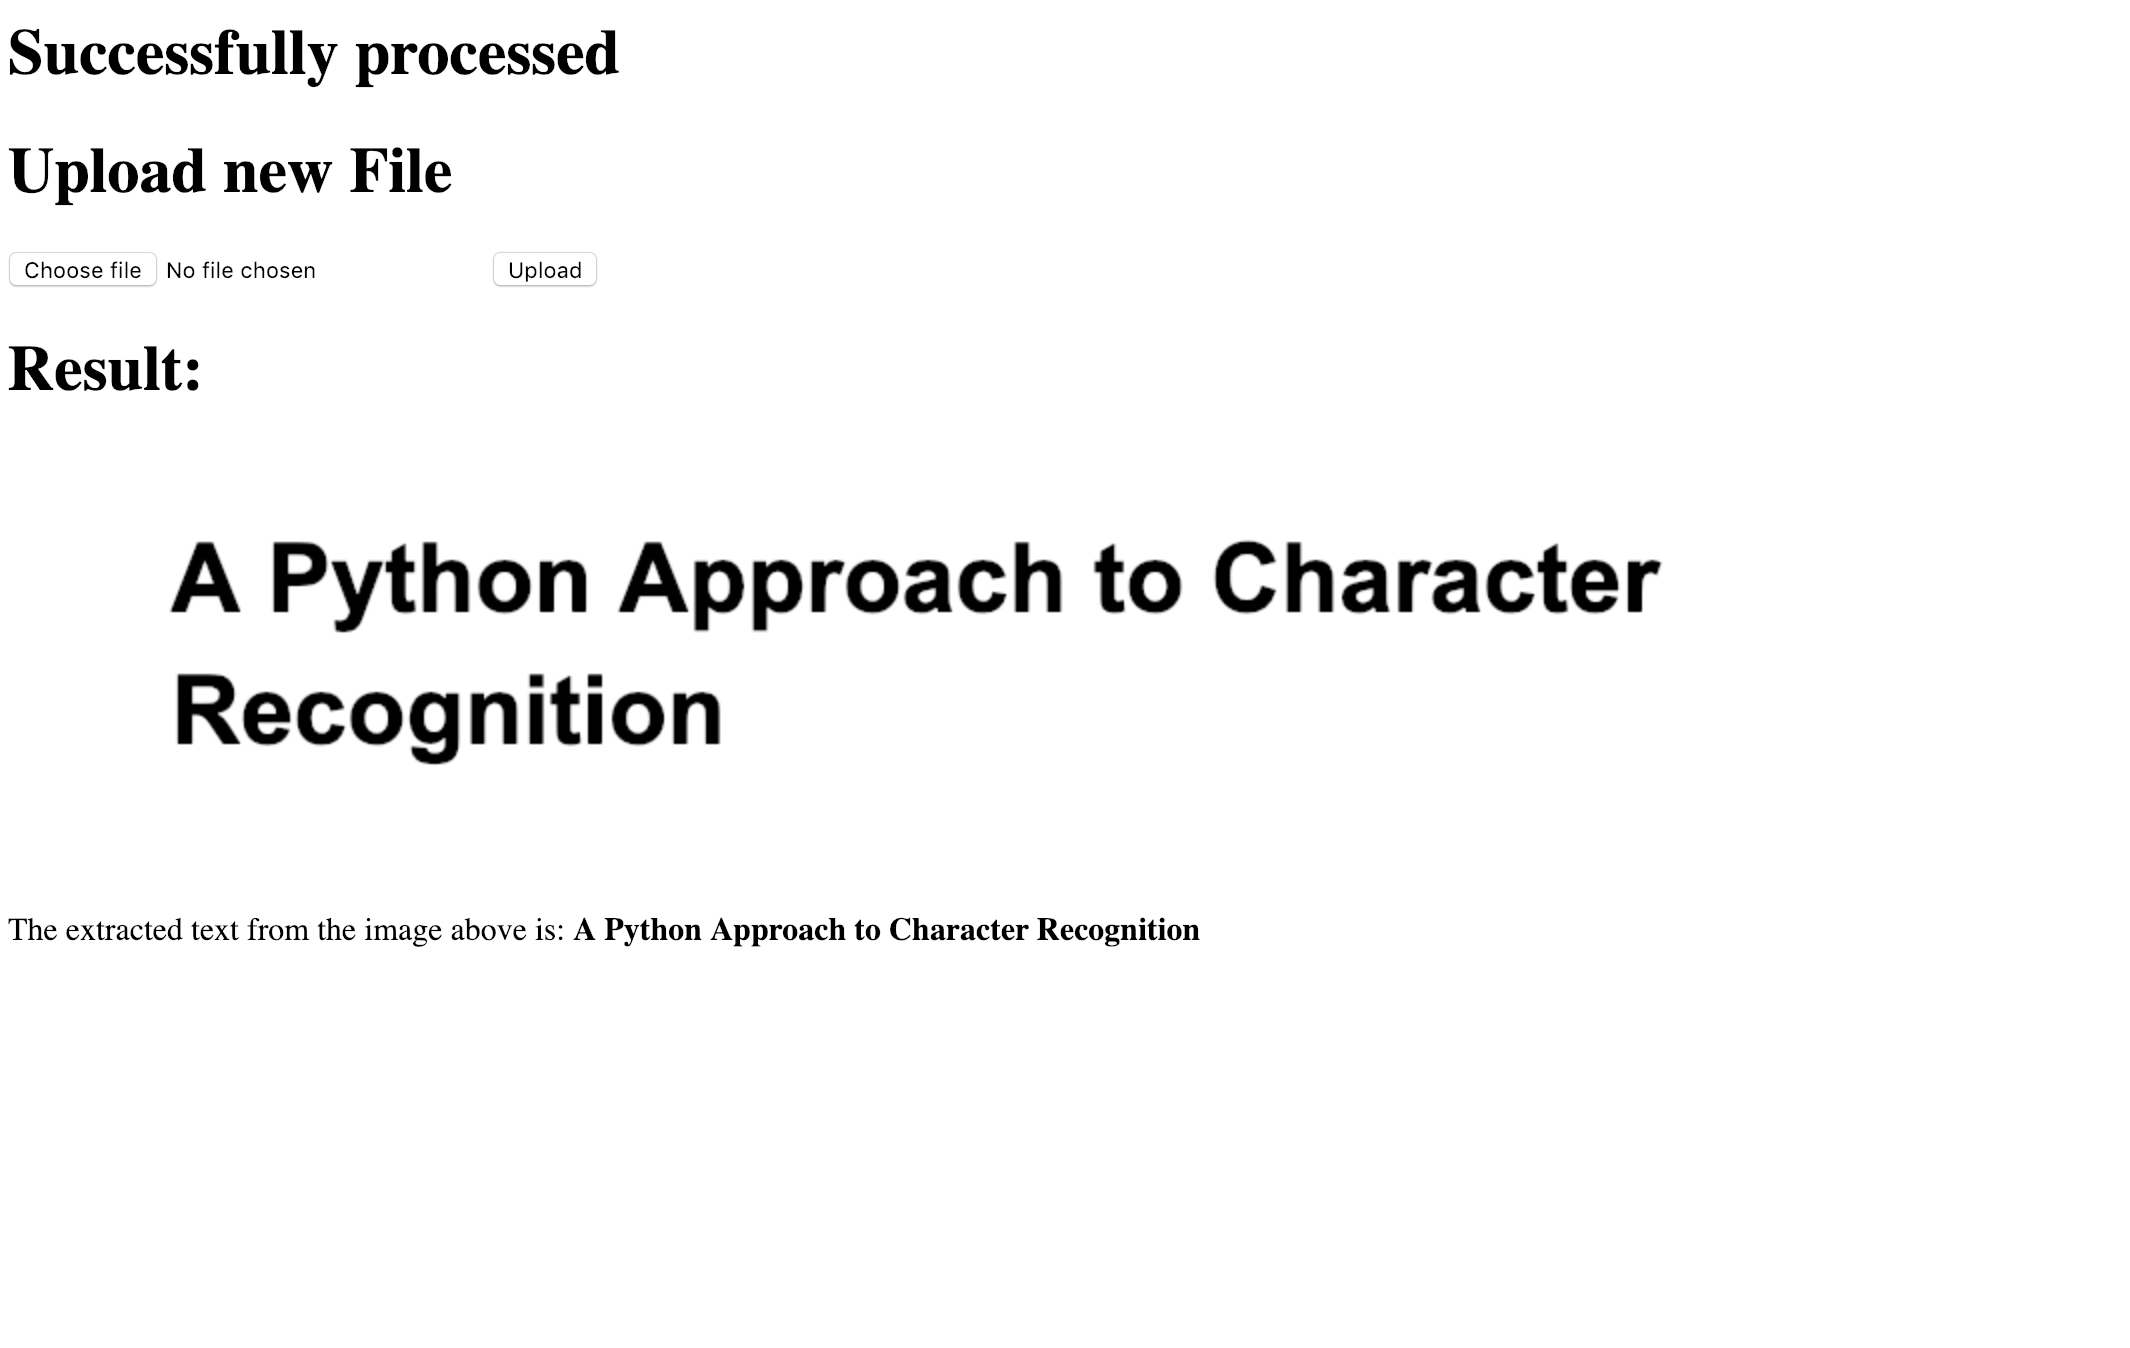

In [91]:
img